In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np
import time
import os

In [3]:
WEIGHTS = 'src/trained_weight/rm_koala/yolov4-tiny_7class_mod_final.weights'
CFG = 'src/cfg/yolov4-tiny_7class_mod.cfg'
NAMES = 'src/cfg/rm_combine.names'
IMAGE_PATH = 'src/images/200-249/red1 200-249 armour/obj_train_data/red_1_frame0249.jpg'
IMAGE_PATH = 'src/images/training/200each/blue_1_frame0138.jpg'
CONFIDENCE_THRESHOLD = 0.3

In [4]:
def imShow(img_path):
    image = cv2.imread(img_path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [15]:
## Load necessary files for model
def load_model(weights, cfg, names):
     
    try:
        model = cv2.dnn.readNet(weights, cfg)

    except Exception as e:
        print(e)
        print('Model loading failed.')
        return

    output_layers = model.getUnconnectedOutLayersNames()

    with open(names, "r") as file:
        classes = [line.strip() for line in file.readlines()]

    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    
    return model, output_layers, classes, colors

In [17]:
load_model(WEIGHTS, CFG, NAMES)

(<dnn_Net 12811570>,
 ['yolo_30', 'yolo_37'],
 ['blue_1', 'blue_2', 'red_1', 'red_2', 'front', 'side', 'back'],
 array([[120.83830546, 201.55153485,  26.11736317],
        [ 86.14606794,  89.89812421, 163.6642729 ],
        [186.95349626, 193.65230242,  87.15947427],
        [245.54358552, 221.50268408,  41.40117184],
        [ 79.29199413, 142.72640551, 138.6398041 ],
        [ 78.42898754,  57.22856715, 120.82976346],
        [ 51.53574239,  37.63916922,  98.79048178]]))

In [21]:
def load_image(image_path):
    
    try:
        image = cv2.imread(image_path)
        image.shape
        
    except Exception as e:
        print(e)
        print('Image loading failed.')
        return
    
    return image
        

In [22]:
image = load_image(IMAGE_PATH)

In [23]:
## Get NMS bounding boxes (standard result)
def get_nms_bboxes(outputs, height, width, confidence_threshold, classes):

    bboxes, confidences, class_ids, nms_bboxes = list(), list(), list(), list()
    
    ## Extract all bounding boxes from the output of the model 
    for output in outputs:
        for detect in output:
            
            scores = detect[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            
            if confidence > confidence_threshold:

                center_x, center_y = int(detect[0] * width), int(detect[1] * height)
                w, h = int(detect[2] * width), int(detect[3] * height)
                x, y = int(center_x - w/2), int(center_y - h/2)
                
                bboxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    ## Calculate Non-Maximum Supression bounding boxes (remove highly overlapped bboxes)
    indexes = cv2.dnn.NMSBoxes(bboxes, confidences, confidence_threshold, 0.4)
    
    for i in indexes.flatten():
        nms_bboxes.append([bboxes[i], confidences[i], class_ids[i], str(classes[class_ids[i]])])

    return nms_bboxes

In [24]:
## Get the largest armor bounding box in the picture
def get_largest_bbox(nms_bboxes):
    
    pose_bboxes = [bbox for bbox in nms_bboxes if bbox[2] > 3]
    armor_bboxes = [bbox for bbox in nms_bboxes if bbox[2] <= 3]
    
    max_area = 0
    
    for armor_bbox in armor_bboxes:
        
        bbox, confidence, class_id, text = armor_bbox
        
        if bbox[2] * bbox[3] > max_area:
            max_area, largest_bbox = bbox[2] * bbox[3], armor_bbox

    return append_pose([largest_bbox], pose_bboxes)

In [25]:
## Get the largest armor bounding boxes for 4 armor types in the picture
def get_largest_bboxes(nms_bboxes):
    
    pose_bboxes = [bbox for bbox in nms_bboxes if bbox[2] > 3]
    armor_bboxes = [bbox for bbox in nms_bboxes if bbox[2] <= 3]
    
    max_bbox_area = [0] * 4
    max_bbox_index = [-1] * 4

    for i in range(len(armor_bboxes)):
        bbox, confidence, armor_id, text = armor_bboxes[i]
        
        if bbox[2] * bbox[3] > max_bbox_area[armor_id]:
            max_bbox_area[armor_id], max_bbox_index[armor_id] = bbox[2] * bbox[3], i
    
#     print(max_bbox_area, max_bbox_index)
            
    filtered_armor_bboxes = list()
            
    for i in list(filter(lambda x: x >= 0, max_bbox_index)):
        
        filtered_armor_bboxes.append(armor_bboxes[i])
        
#     print(filtered_armor_bboxes)
        
    return append_pose(filtered_armor_bboxes, pose_bboxes)

In [26]:
## Append the proper pose label to each armor labels
def append_pose(armor_bboxes, pose_bboxes):
    
    ## Check if the center of bbox_in is within bbox_out
    def contain_bbox(bbox_out, bbox_in):
    
        x_o, y_o, w_o, h_o = bbox_out
        x_i, y_i, _, _ = bbox_in

        return x_i > x_o and x_i < x_o + w_o and y_i > y_o and y_i < y_o + h_o
    
    for i in range(len(armor_bboxes)):
        bbox_in, _, _, text_in = armor_bboxes[i]
        
        for pose_bbox in pose_bboxes:
            bbox_out, _, _, text_out = pose_bbox
            
            if contain_bbox(bbox_out, bbox_in):
                break
                
        armor_bboxes[i][3] = text_in + '_' + text_out
        
    return armor_bboxes

In [28]:
# accepts image and outputs layers as parameters
def positioning_bboxes(image, model, output_layers, mode = 3):
    
    height, width, channels = image.shape
    
    ## Image preprocessing
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0/255, size=(320, 320), mean=(0, 0, 0), swapRB=True, crop=False)
    
    ## Forward pass through the model and get the raw output
    model.setInput(blob)
    outputs = model.forward(output_layers)

    ## Obtain bounding boxes from the raw output
    nms_bboxes = get_nms_bboxes(outputs, height, width, CONFIDENCE_THRESHOLD, classes)
    

    ## Scenario 1 - Find the largest armor pad and identify the pose
    if mode == 2:
        return get_largest_bbox(nms_bboxes)
    
    ## Scenario 2 - Scenario 1 + Consider the possibility of multiple robots in the image
    elif mode == 3:
        return get_largest_bboxes(nms_bboxes)
    
    ## Scenario 3 - Display armor and pose separately
    else:
        return nms_bboxes

In [29]:
## Draw the predicted bounding boxes and labels on the image
def draw_labels(image, bboxes, classes, colors): 
    
    font = cv2.FONT_HERSHEY_PLAIN

    for i in range(len(bboxes)):
        
        bbox, confidence, class_id, text = bboxes[i]

        x, y, w, h = bbox
        label = text + "  " + str(round(confidence, 3))
        color = colors[class_id]
        cv2.rectangle(image, (x,y), (x+w, y+h), color, 2)
        cv2.putText(image, label, (x, y - 5), font, 1, color, 1)
        
    ## Output prediction result to file
    cv2.imwrite('prediction.jpg', image)
    
    ## Show prediction result (for verification only)
    imShow('prediction.jpg')

In [30]:
## Load necessary files for model (must do this before detection)
model, output_layers, classes, colors = load_model(WEIGHTS, CFG, NAMES)

In [31]:
def image_detect(image_path, mode): 
    
    tstart = time.perf_counter()
    image = load_image(image_path)
    bboxes = positioning_bboxes(image, model, output_layers, mode)
    print('processing time on CPU: ', time.perf_counter() - tstart)
    draw_labels(image, bboxes, classes, colors)
    print('processing time on CPU: ', time.perf_counter() - tstart)

In [33]:
IMAGE_PATH = 'src/images/training/200each/blue_1_frame0100.jpg'

In [35]:
IMAGE_PATH = 'multiple_colours.png'

processing time on CPU:  0.10047149999991234


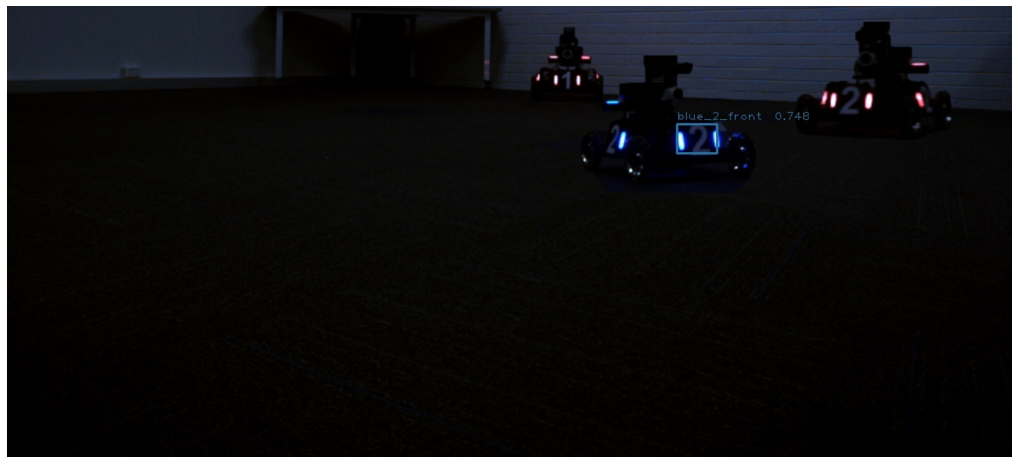

processing time on CPU:  2.0756690999999137


In [36]:
image_detect(os.path.abspath(IMAGE_PATH), 2)